In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# problem 3

In [3]:
class MF():
    def __init__(self):
        # given parameter
        self.var = 0.25
        self.d = 10
        self.lamb = 1
        self.iter = 100
        # import data
        self.import_data()
        
    def import_data(self):
        # import data
        rating = pd.read_csv('Prob3_ratings.csv', header = None,
                             names = ['user_id','movie_id','rating'])
        
        # import test data
        rating_test = pd.read_csv('Prob3_ratings.csv', header = None, 
                                  names = ['user_id','movie_id','rating'])
        
        # extract number of user and movies
        self.N1, self.N2 = rating.user_id.max(), rating.movie_id.max()
        
        # construct M matrix
        self.M = np.ndarray((self.N1,self.N2))
        self.M[:] = np.nan
        self.M[rating.user_id.values - 1, 
               rating.movie_id.values - 1] = rating.rating.values
        
        # construct M_test matrix
        self.M_t = np.ndarray((self.N1,self.N2))
        self.M_t[:] = np.nan
        self.M_t[rating_test.user_id.values - 1, 
                 rating_test.movie_id.values - 1] = rating_test.rating.values
        
        # extract observed index
        self.ob_ind = ~np.isnan(self.M)
        self.ob_ind_t = ~np.isnan(self.M_t)
        
        # N1 * N2 - missing cells - # of data = 0
        assert (int(self.N1 * self.N2) - 
                np.isnan(self.M).sum() - rating.shape[0]) == 0
        
    def P_MF(self):
        # factorized user
        self.user = np.ndarray((self.N1, self.d))
        self.user[:] = np.nan
        
        # factorized movie with initial value
        self.movie = np.random.multivariate_normal(
            np.zeros(self.d), np.identity(self.d)/self.lamb, self.N2).T
        
        # ovjective function
        self.obj = np.ndarray(self.iter)
        self.obj[:] = np.nan
        
        # update user location
        for i in range(self.iter):
            self.update_user()
            self.update_loc()
            self.score(i)
            
        self.error()
    
    def update_user(self):
        for i in range(self.N1):
            tmp_m = self.movie[:, self.ob_ind[i,:] ] 
            tmp_M = self.M[i, self.ob_ind[i,:]] 
            self.user[i,:] = np.linalg.inv( 
                self.lamb * self.var * np.identity(self.d) +
                tmp_m.dot(tmp_m.T) ).dot(tmp_m.dot(tmp_M.T))
        
    def update_loc(self):
        for j in range(self.N2):
            tmp_u = self.user[self.ob_ind[:,j],:]
            tmp_M = self.M[self.ob_ind[:,j],j]
            self.movie[:,j] = np.linalg.inv( 
                self.lamb * self.var * np.identity(self.d) + 
                tmp_u.T.dot(tmp_u)).dot(tmp_u.T.dot(tmp_M.T))
            
    def score(self,i):
        M_est = self.user.dot(self.movie)
        self.obj[i] = - np.sum((self.M[self.ob_ind] - M_est[self.ob_ind])**2)/2/self.var
        self.obj[i] -= np.sum(np.einsum('ij,ij->i', self.user, self.user))*self.lamb/2
        self.obj[i] -= np.sum(np.einsum('ij,ij->i', self.movie, self.movie))*self.lamb/2
        
    def error(self):
        M_est = self.user.dot(self.movie)
        self.rmse = np.sqrt(
            np.sum((self.M_t[self.ob_ind_t] - M_est[self.ob_ind_t])**2) / 
            np.sum(self.ob_ind_t))

In [4]:
mf = {}
for i in range(10):
    #print('run ' + str(i))
    mf[i] = MF()
    mf[i].P_MF()

In [5]:
obj = np.ndarray((10, 99))
rmse = np.ndarray(10)
for i in range(10):
    obj[i,:] = mf[i].obj[1:]
    rmse[i] = mf[i].rmse

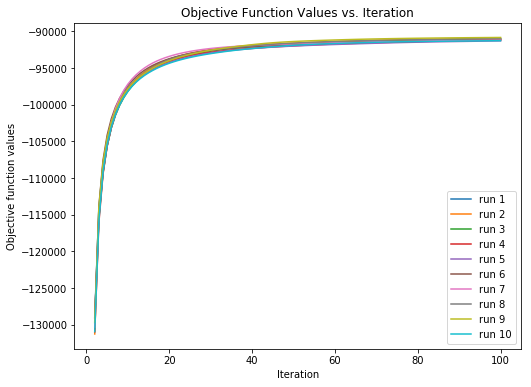

In [6]:
plt.figure(figsize=(8, 6))
for i in range(10):
    sns.lineplot(x= range(2,101), y = obj[i,:], label = 'run ' + str(i+1))
_ = plt.xlabel('Iteration')
_ = plt.ylabel('Objective function values')
_ = plt.title('Objective Function Values vs. Iteration')

In [7]:
result = np.ndarray((10, 3))
for i in range(10):
    result[i,:] = int(i+1), mf[i].obj[-1], mf[i].rmse
result = pd.DataFrame(result, columns = ['run #', 'Obj Value', 'RMSE'])
result['Rank'] = result['Obj Value'].rank(ascending=False)
result.sort_values("Rank", inplace = True) 
result

,run #,Obj Value,RMSE,Rank
8,9.0,-90823.847291,0.673369,1.0
7,8.0,-90976.999659,0.673904,2.0
1,2.0,-90977.862889,0.673725,3.0
2,3.0,-90978.237375,0.674018,4.0
0,1.0,-91084.361586,0.674189,5.0
3,4.0,-91141.527197,0.674347,6.0
5,6.0,-91168.019391,0.674507,7.0
6,7.0,-91173.025091,0.674398,8.0
9,10.0,-91261.485445,0.674695,9.0
4,5.0,-91288.965396,0.674875,10.0


In [8]:
# proble 3b

In [9]:
# read movie names
names = pd.read_csv('Prob3_movies.txt', 
                    header=None, sep = '\n', 
                    names = ['name'])
# set movie names
movies = 'Star Wars|My Fair Lady|GoodFellas'
# extract index
ind = names[names.name.str.contains(movies)].index

In [10]:
# extract best model's v matrix
v_matrix = mf[result.index[0]].movie.T

In [11]:
similar_table={}
for i in range(3):
    diff = v_matrix - v_matrix[ind[i]]
    dis_list = pd.DataFrame(np.einsum('ij,ij->i', diff, diff), columns=['Distance'])
    similar = dis_list.sort_values('Distance').head(11)
    similar['Name'] = names.iloc[similar.index]
    similar_table[i] = pd.DataFrame(similar)

In [15]:
print(similar_table[0])

      Distance                                       Name
49    0.000000                           Star Wars (1977)
171   0.099517            Empire Strikes Back, The (1980)
173   0.254445             Raiders of the Lost Ark (1981)
180   0.405606                  Return of the Jedi (1983)
172   0.618292                 Princess Bride, The (1987)
428   0.704261      Day the Earth Stood Still, The (1951)
612   0.779787                      My Man Godfrey (1936)
209   0.786532  Indiana Jones and the Last Crusade (1989)
193   0.809872                          Sting, The (1973)
1006  0.853839                 Waiting for Guffman (1996)
152   0.857303                Fish Called Wanda, A (1988)


In [16]:
print(similar_table[1])

     Distance                                    Name
181  0.000000                       GoodFellas (1990)
692  0.317113                           Casino (1995)
187  0.414579                Full Metal Jacket (1987)
176  0.514571  Good, The Bad and The Ugly, The (1966)
55   0.796721                     Pulp Fiction (1994)
645  0.809231     Once Upon a Time in the West (1969)
182  0.810928                            Alien (1979)
522  0.913397                   Cool Hand Luke (1967)
503  1.031519                 Bonnie and Clyde (1967)
184  1.032881                           Psycho (1960)
186  1.036880          Godfather: Part II, The (1974)


In [17]:
print(similar_table[2])

      Distance                                          Name
484   0.000000                           My Fair Lady (1964)
418   0.494611                           Mary Poppins (1964)
98    0.792115        Snow White and the Seven Dwarfs (1937)
417   0.868884                             Cinderella (1950)
419   0.898732                    Alice in Wonderland (1951)
142   0.899821                    Sound of Music, The (1965)
968   0.904088   Winnie the Pooh and the Blustery Day (1968)
1146  0.961298                              My Family (1995)
431   1.008023                               Fantasia (1940)
601   1.031740                  American in Paris, An (1951)
150   1.144325  Willy Wonka and the Chocolate Factory (1971)
